In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
import os


#os.chdir('drive/MyDrive/CentralValleyWaterProject/CDEC_data')



In [4]:
# Function to load and preprocess data
def load_and_preprocess_data(station):
    filename = f'{station}.csv'
    df = pd.read_csv(filename)
    df['DATE TIME'] = pd.to_datetime(df['DATE TIME'], format='%Y%m%d %H%M')
    df = df.rename(columns={'DATE TIME': 'date', 'VALUE': f'{station}_value'})
    df = df.set_index('date')
    df[f'{station}_value'] = pd.to_numeric(df[f'{station}_value'], errors='coerce')
    return df[[f'{station}_value']]  # Only return the value column

# Load CDEC data
stations = ['YDR', 'TIS', 'SUT', 'SJP', 'SJN', 'SJF', 'SBS', 'RVB', 'NIC', 'LIS', 'KNL', 'GRL', 'FRE', 'FPT', 'DLT', 'BTC']
data = {}

for station in stations:
    try:
        data[station] = load_and_preprocess_data(station)
        print(f"Loaded data for {station}")
    except FileNotFoundError:
        print(f"Warning: File for {station} not found")

# Combine all datasets
combined_df = pd.concat(data.values(), axis=1)
combined_df = combined_df.resample('D').mean()  # Resample to daily frequency

Loaded data for YDR
Loaded data for TIS


<ipython-input-4-b034011a9067>:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


Loaded data for SUT
Loaded data for SJP


<ipython-input-4-b034011a9067>:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


Loaded data for SJN
Loaded data for SJF
Loaded data for SBS
Loaded data for RVB
Loaded data for NIC


<ipython-input-4-b034011a9067>:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


Loaded data for LIS
Loaded data for KNL
Loaded data for GRL
Loaded data for FRE
Loaded data for FPT
Loaded data for DLT
Loaded data for BTC


In [12]:
# Create features
combined_df['month'] = combined_df.index.month
combined_df['day_of_year'] = combined_df.index.dayofyear

# Select a target variable (e.g., 'YDR_value' for Yolo Bypass)
target_variable = 'YDR_value'

# Prepare data for modeling
X = combined_df.drop(columns=[target_variable])
y = combined_df[target_variable]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_imputed, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# Ensemble prediction (simple average)
ensemble_pred = (rf_pred + gb_pred) / 2

Random Forest - MSE: 0.1353, R2: 0.7964
Gradient Boosting - MSE: 0.2232, R2: 0.6640
Ensemble - MSE: 0.1525, R2: 0.7704

Top 10 important features:
        feature  importance
3     SJN_value    0.246045
2     SJP_value    0.152826
12    FPT_value    0.135985
10    GRL_value    0.089985
11    FRE_value    0.056693
13    DLT_value    0.047637
5     SBS_value    0.041515
1     SUT_value    0.041197
14    BTC_value    0.039572
16  day_of_year    0.038349


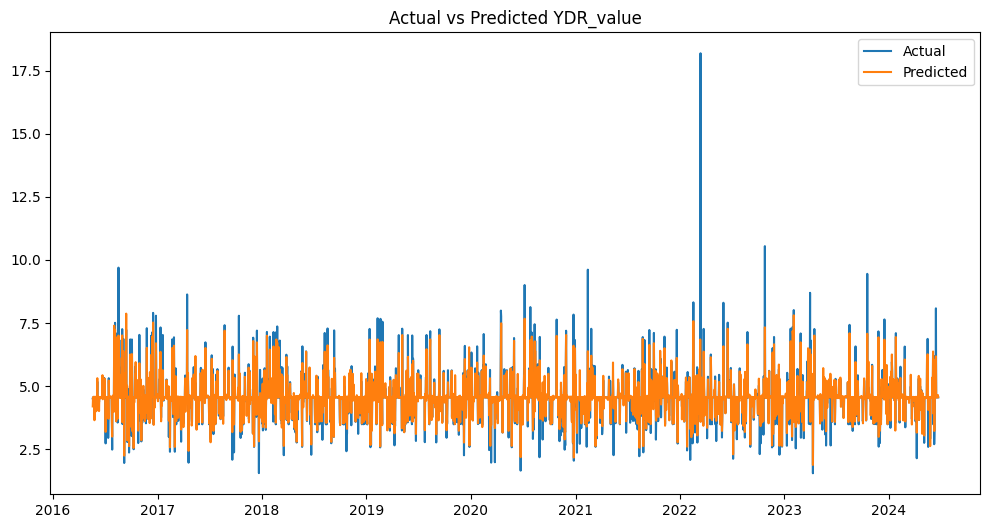

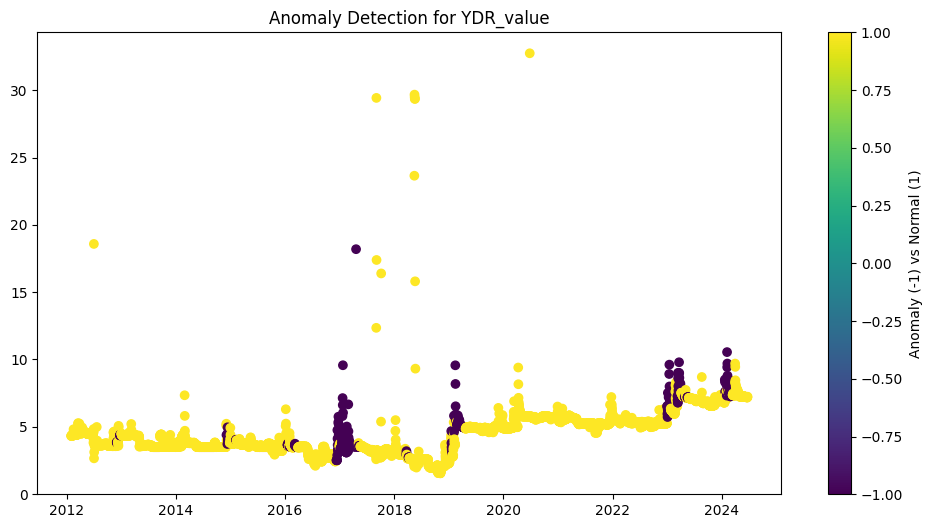

In [13]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}")

evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, gb_pred, "Gradient Boosting")
evaluate_model(y_test, ensemble_pred, "Ensemble")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 important features:")
print(feature_importance.head(10))

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index[-len(y_test):], y_test, label='Actual')
plt.plot(combined_df.index[-len(y_test):], ensemble_pred, label='Predicted')
plt.title(f'Actual vs Predicted {target_variable}')
plt.legend()
plt.show()

# Anomaly Detection
isolation_forest = IsolationForest(contamination=0.05, random_state=42)

# Use the imputed and scaled data for anomaly detection
X_imputed_scaled = scaler.fit_transform(imputer.fit_transform(X))
anomalies = isolation_forest.fit_predict(X_imputed_scaled)

# Add anomaly results to the original dataframe
combined_df['anomaly'] = anomalies

# Visualize anomalies
plt.figure(figsize=(12, 6))
non_nan_mask = ~np.isnan(combined_df[target_variable])
plt.scatter(combined_df.index[non_nan_mask],
            combined_df[target_variable][non_nan_mask],
            c=combined_df['anomaly'][non_nan_mask],
            cmap='viridis')
plt.title(f'Anomaly Detection for {target_variable}')
plt.colorbar(label='Anomaly (-1) vs Normal (1)')
plt.show()

In [14]:
# Generate report
from mdutils.mdutils import MdUtils
from mdutils import Html
import io
import base64

mdFile = MdUtils(file_name='water_level_prediction_report', title='Water Level Prediction and Anomaly Detection Report')

def add_plot_to_md(fig, mdFile, title):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_str = base64.b64encode(buf.getvalue()).decode('utf-8')
    mdFile.new_header(level=2, title=title)
    mdFile.new_paragraph(Html.image(path='data:image/png;base64,'+img_str, size='800x600'))

mdFile.new_header(level=1, title="Introduction")
mdFile.new_paragraph("This report presents an analysis of water levels in California's Central Valley using ensemble methods for prediction and anomaly detection.")

mdFile.new_header(level=1, title="Data Description")
mdFile.new_paragraph(f"The analysis uses data from {len(stations)} CDEC stations, including {', '.join(stations)}. Data was preprocessed, resampled to daily frequency, and missing values were imputed.")

mdFile.new_header(level=1, title="Model Performance")
mdFile.new_paragraph("Model performance metrics:")
mdFile.new_paragraph(f"Random Forest - MSE: {mean_squared_error(y_test_imputed, rf_pred):.4f}, R2: {r2_score(y_test_imputed, rf_pred):.4f}")
mdFile.new_paragraph(f"Gradient Boosting - MSE: {mean_squared_error(y_test_imputed, gb_pred):.4f}, R2: {r2_score(y_test_imputed, gb_pred):.4f}")
mdFile.new_paragraph(f"Ensemble - MSE: {mean_squared_error(y_test_imputed, ensemble_pred):.4f}, R2: {r2_score(y_test_imputed, ensemble_pred):.4f}")

mdFile.new_header(level=1, title="Feature Importance")
mdFile.new_paragraph("Top 10 important features:")
mdFile.new_paragraph(feature_importance.head(10).to_markdown())

add_plot_to_md(plt.gcf(), mdFile, 'Actual vs Predicted Water Levels')
add_plot_to_md(plt.gcf(), mdFile, 'Anomaly Detection')

mdFile.new_header(level=1, title="Conclusion")
mdFile.new_paragraph("This analysis provides insights into water level patterns and anomalies in California's Central Valley. The ensemble model shows good predictive performance, and the anomaly detection highlights unusual water level events.")

mdFile.create_md_file()
print("Report generated: water_level_prediction_report.md")

Report generated: water_level_prediction_report.md


<Figure size 640x480 with 0 Axes>